지난 시간엔 주식 분산투자를 구현해봤습니다.
삼성, 카카오, 현대차 등 분산투자 하여 5개 종목의 평균적인 수익률과 mdd를 얻을 수 있었지만,
주식의 특성상 변동성이 높은 것은 어찌할 방법이 없습니다.
우리가 원하는 것은 분산투자 그 이상으로 리스크를 낮추는 것입니다.

주식의 높은 리스크를 관리할 수 있는 방법 중 하나는 바로 채권혼합입니다.

채권을 혼합하는 이유는 일반적으로 채권은 주식과 가격 움직임이 반대이기 때문입니다.  
서로 반대로 움직이는 종목으로 포트폴리오를 구성하여 한쪽이 하락할 때 그 손실을 줄이는 것이 목적입니다.  


In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 함수

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

# 채권 혼합

In [3]:
# 코스피 ETF 채권 ETF 1:1 혼합

# 데이터 로드
kodex200 = getCloseData("069500", "2000") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21792,49960.0
2012-01-25,21868,49960.0
2012-01-26,21889,49930.0
2012-01-27,21923,50000.0
2012-01-30,21675,50130.0
...,...,...
2022-06-16,32265,61355.0
2022-06-17,32025,61255.0
2022-06-20,31510,61370.0


In [4]:
# 결측치 가볍게 검사
pd.isnull(closeDataSet).sum()

kodex200       0
kodex10Bond    0
dtype: int64

**주식과 채권의 움직임 비교**

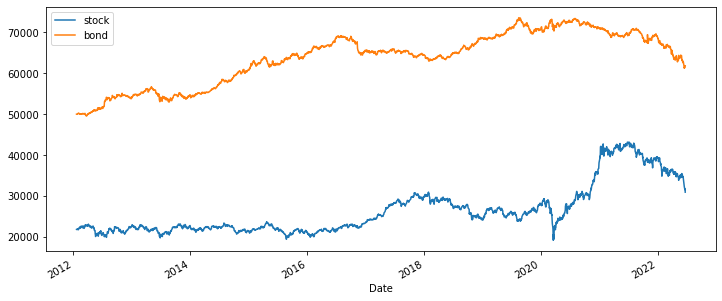

In [5]:
plt.figure(figsize=(12, 5))
closeDataSet['kodex200'].plot(label="stock")
closeDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

가격 수준이 다르기 때문에 비교가 쉽지 않습니다.  
정규화를 통해 해결해볼까요?  
정규분포의 특성을 이용해 자료의 평균으로부터 어느정도 떨어져있는지에 대한 값으로 사용할 수 있습니다.  
서로 다른 가격 수준을 가지더라도 평균이 0이고 표준편차가 1인 정규분포 형태로 만들어서 서로 다른 가격 수준을 가진 주가라도 그 움직임을 보다 간편하게 확인할 수 있습니다.

정규분포에 관한 자세한 내용은 검색해보시길..  

정규화 = $ \frac{주가 - 주가 평균}{주가 표준편차} $

In [6]:
# 데이터 정규화
normalizedCloseDataSet = (closeDataSet - closeDataSet.mean()) / closeDataSet.std()

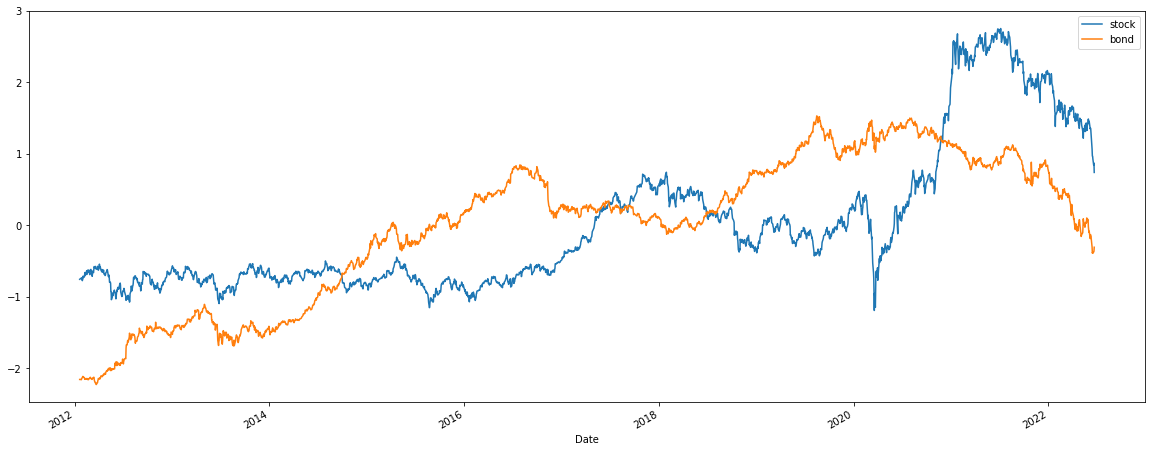

In [7]:
# 정규화 가격 시각화
plt.figure(figsize=(20, 8))
normalizedCloseDataSet['kodex200'].plot(label="stock")
normalizedCloseDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

최근 2022년부터는 금리인상으로 인해 채권과 주식 가격이 커플링되는 현상이 나타났지만, 일반적으로 채권과 주식은 반대로 움직이는 것을 확인했습니다.

### 주식 ETF 성과

우선 KODEX200은 코스피 200에 랭크된 종목에 골고루 분산투자하는 ETF입니다.  
이로 인해 분산투자를 했다고 가정하고,
주식 분산 투자 성과를 계산해보겠습니다.

In [8]:
kodex200DayReturn = getDayReturn(closeDataSet['kodex200'])
kodex200CumReturn = getCumulativeReturn(closeDataSet['kodex200'])

kodex200Cagr, kodex200Dd, kodex200Mdd = getEvaluation(kodex200CumReturn)

cagr: 1.0348849273517033
mdd: 38.08322008671455


In [9]:
kodex200CumReturn

Date
2012-01-20    1.000000
2012-01-25    1.003488
2012-01-26    1.004451
2012-01-27    1.006011
2012-01-30    0.994631
                ...   
2022-06-16    1.480589
2022-06-17    1.469576
2022-06-20    1.445943
2022-06-21    1.454203
2022-06-22    1.417493
Name: kodex200, Length: 2564, dtype: float64

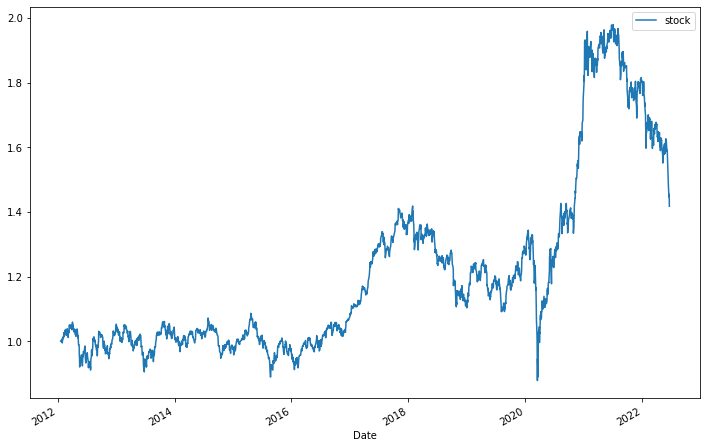

In [10]:
plt.figure(figsize=(12, 8))
kodex200CumReturn.plot(label="stock")
plt.legend()
plt.show()

연평균 수익률이 4.7%이면 나쁘지 않을 수 있지만, MDD가 약 38%입니다.  
결코 낮지 않은 수치입니다.

## 채권 ETF와 1:1 혼합할 때 성과

In [11]:
# 지난번 구현해둔 함수를 사용해서 간편하게 구할 수 있음
portDayReturn, portCumReturn = getPortfolioResult(closeDataSet)

In [12]:
portCumReturn

Date
2012-01-20    1.000000
2012-01-25    1.001744
2012-01-26    1.001925
2012-01-27    1.003406
2012-01-30    0.999017
                ...   
2022-06-16    1.354336
2022-06-17    1.347828
2022-06-20    1.337163
2022-06-21    1.341894
2022-06-22    1.327141
Length: 2564, dtype: float64

In [38]:
# 투자 성과 cagr, dd, mdd
print("주식: 채권 1:1 10년 최종수익률")
print(portCumReturn.iloc[-1])
portCagr, portDd, portMdd = getEvaluation(portCumReturn)

주식: 채권 1:1 10년 최종수익률
1.327141044700665
cagr: 1.0282075154963335
mdd: 21.572430346937836


**시각화**

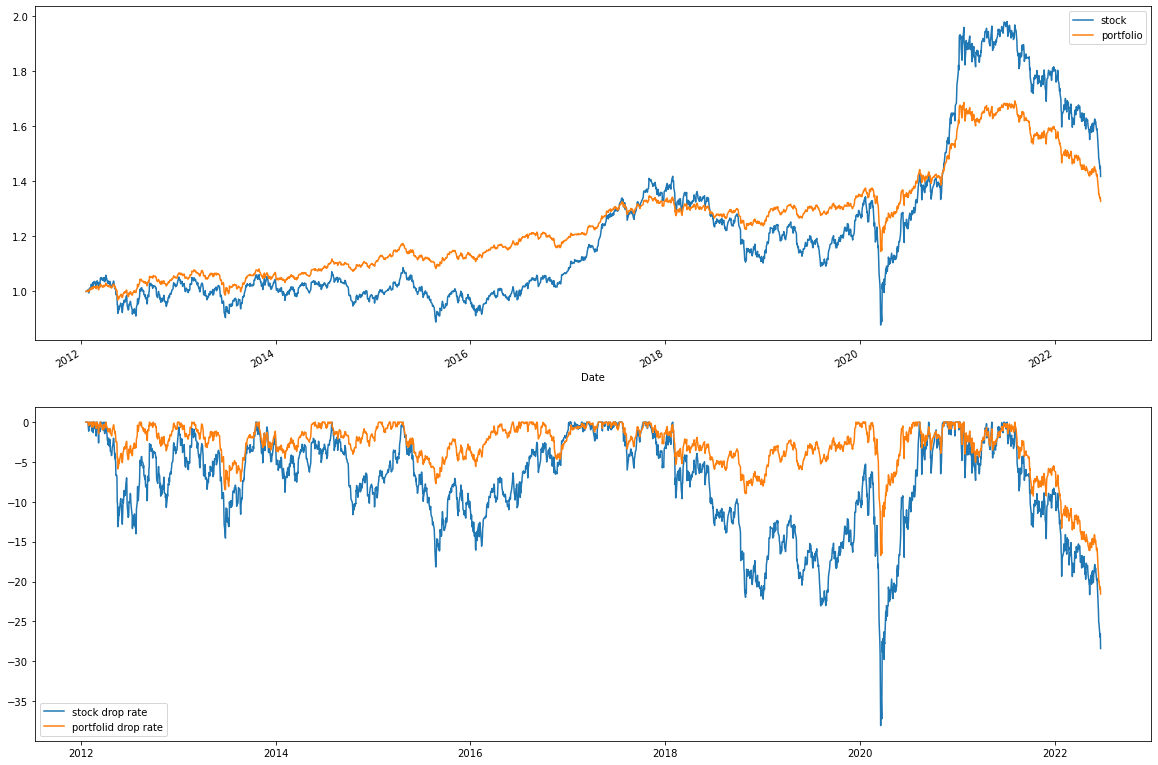

In [14]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd * -1, label="portfolid drop rate")
plt.legend()

plt.show()

코스피200 ETF에만 투자했을 땐 MDD가 38%에 달했지만  
채권 ETF를 혼합했을 땐 MDD가 16.7%로 약 20% 이상 감소하여 효과적으로 리스크를 관리했습니다.

## 주식 현금 1:1 혼합

In [24]:
kodex200

Date
2002-10-14     5412
2002-10-15     5545
2002-10-16     5569
2002-10-17     5646
2002-10-18     5886
              ...  
2022-06-16    32265
2022-06-17    32025
2022-06-20    31510
2022-06-21    31690
2022-06-22    30890
Name: Close, Length: 4870, dtype: int64

In [35]:
closeDataSet2 = pd.DataFrame(kodex200)
closeDataSet2.columns = ['kodex200']
closeDataSet2.loc[:, 'cash'] = 1
closeDataSet2 = closeDataSet2.loc['2012-01-20':]
closeDataSet2

,kodex200,cash
Date,,
2012-01-20,21792,1
2012-01-25,21868,1
2012-01-26,21889,1
2012-01-27,21923,1
2012-01-30,21675,1
...,...,...
2022-06-16,32265,1
2022-06-17,32025,1
2022-06-20,31510,1


In [41]:
# 주식 현금 포트폴리오 성과
portDayReturn2, portCumReturn2 = getPortfolioResult(closeDataSet2)
print("주식:현금 1:1 혼합 포트폴리오 최종수익률")
print(portCumReturn2.iloc[-1])
portCagr2, portDd2, portMdd2 = getEvaluation(portCumReturn2)

주식:현금 1:1 혼합 포트폴리오 최종수익률
1.2087463289280471
cagr: 1.0188077126012767
mdd: 22.334813465406647


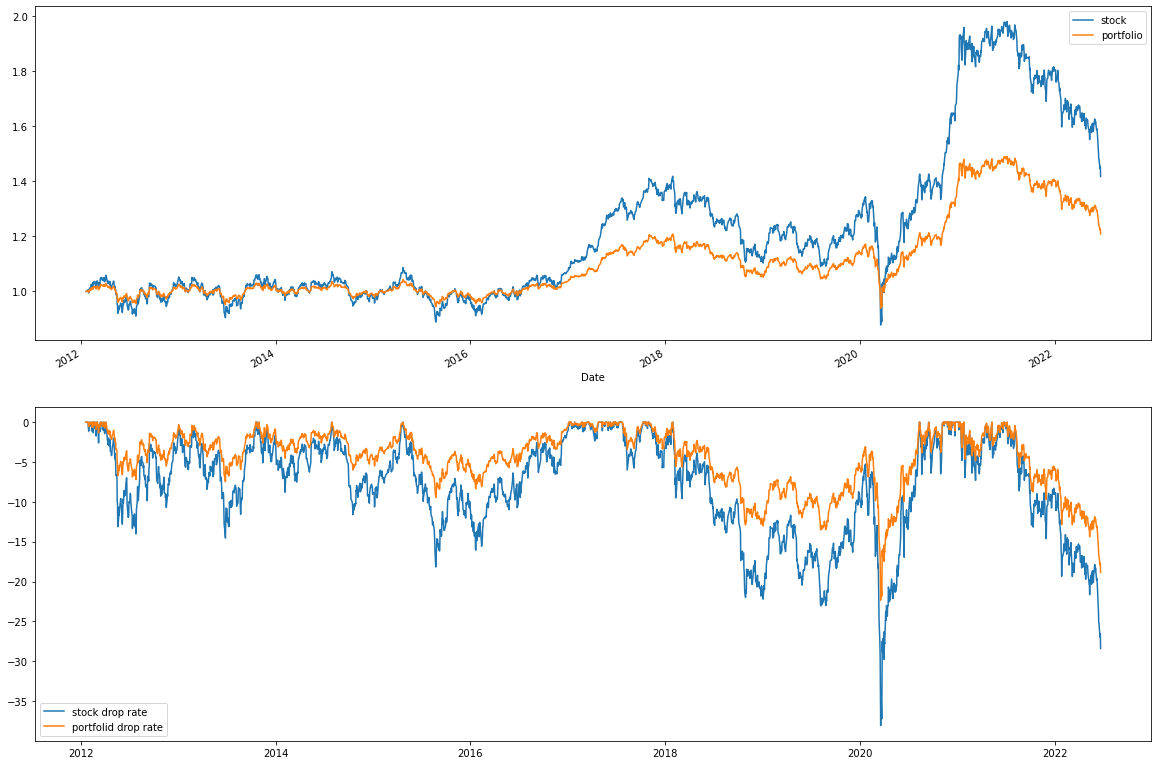

In [37]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn2.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd2 * -1, label="portfolid drop rate")
plt.legend()

plt.show()

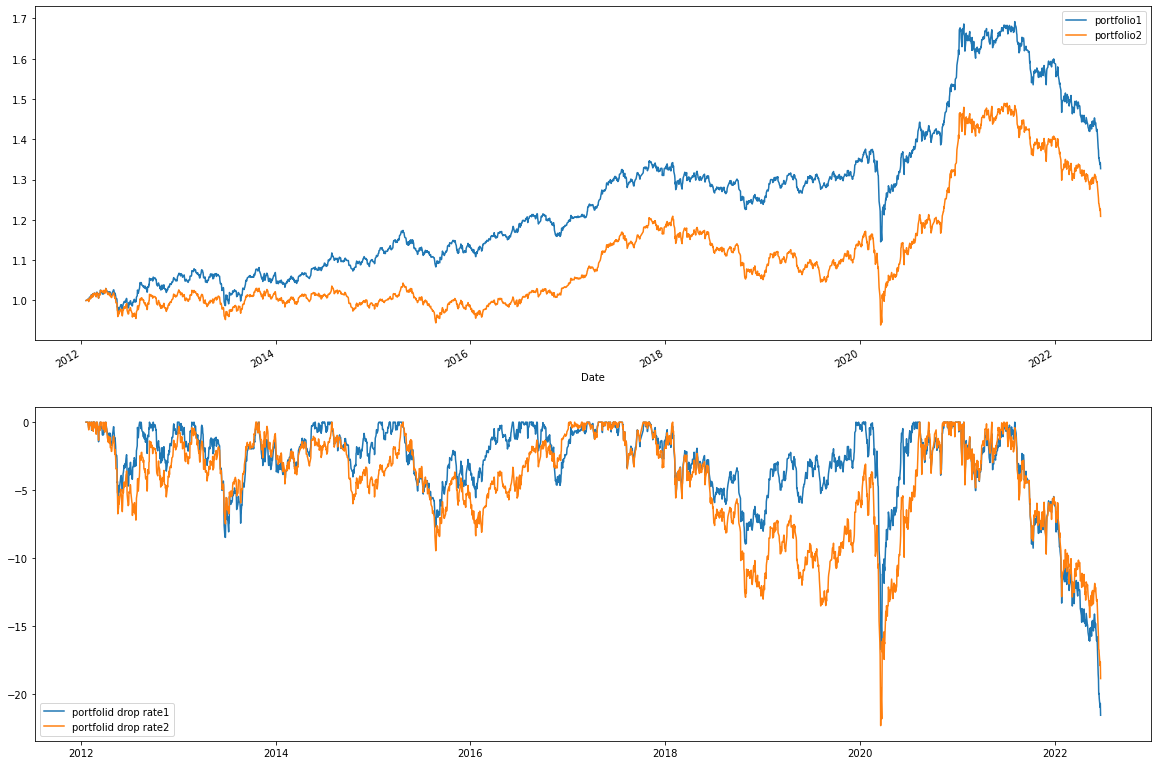

In [39]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
portCumReturn.plot(label="portfolio1")
portCumReturn2.plot(label="portfolio2")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(portDd * -1, label="portfolid drop rate1")
plt.plot(portDd2 * -1, label="portfolid drop rate2")
plt.legend()

plt.show()

## 단기채권

In [45]:
kodexShortBond = getCloseData("153130", "2012")
closeDataSet3 = pd.DataFrame(kodex200)
closeDataSet3.columns = ['kodex200']
closeDataSet3 = pd.concat([closeDataSet3, kodexShortBond], axis=1)
closeDataSet3.dropna(inplace=True)
closeDataSet3

,kodex200,Close
Date,,
2012-02-22,22578,87277.0
2012-02-23,22388,87299.0
2012-02-24,22482,87303.0
2012-02-27,22184,87308.0
2012-02-28,22356,87320.0
...,...,...
2022-06-16,32265,103345.0
2022-06-17,32025,103365.0
2022-06-20,31510,103380.0


In [46]:
portDayReturn3, portCumReturn3 = getPortfolioResult(closeDataSet3)
print("주식:단기채 1:1 혼합 포트폴리오 최종수익률")
print(portCumReturn3.iloc[-1])
portCagr3, portDd3, portMdd3 = getEvaluation(portCumReturn3)

주식:단기채 1:1 혼합 포트폴리오 최종수익률
1.2764398234480794
cagr: 1.0244816010484057
mdd: 19.246474601219383


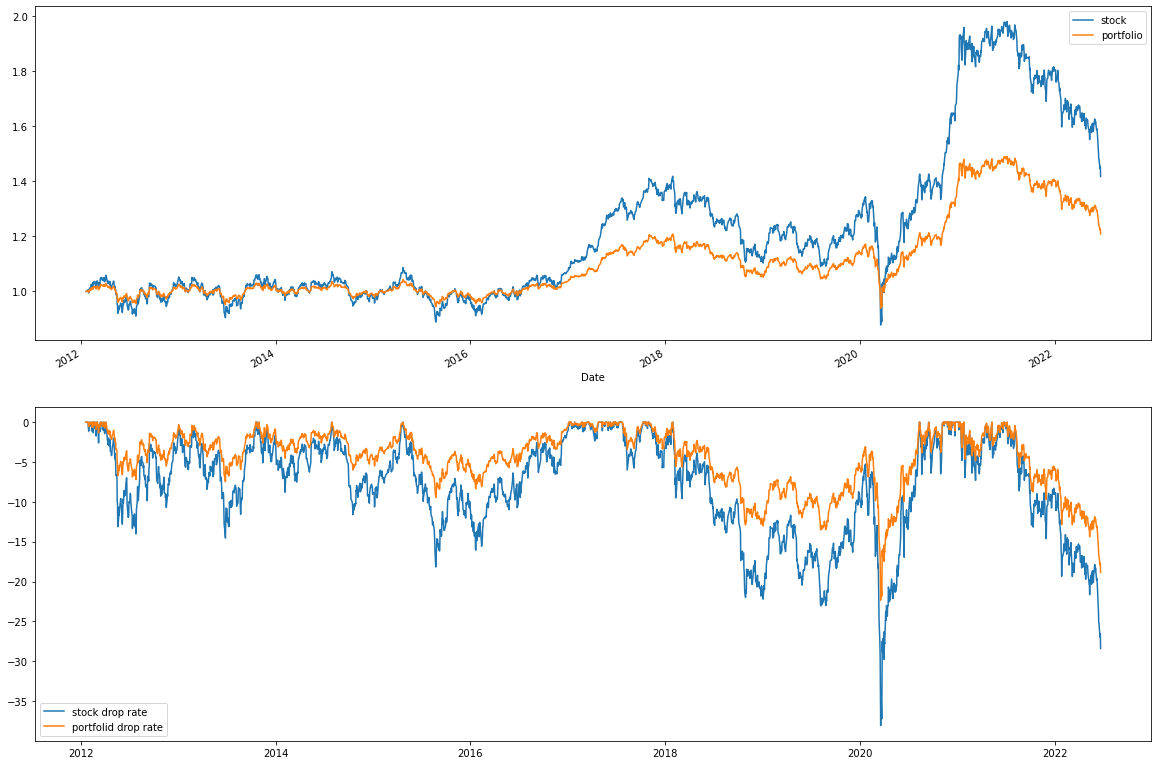

In [48]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn2.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd2 * -1, label="portfolid drop rate")
plt.legend()

plt.show()